# Fake Review Detection
Irina Stroescu & Eric Szabó

Import statements and downloading the dataset

In [2]:
!pip install textstat -q
!pip install liwc -q
!pip install language_tool_python -q
!pip install eli5 -q
!pip install gdown==4.6.0 -q

import re
import spacy
import liwc
import pandas as pd
import numpy as np
import csv
import nltk
import eli5
import language_tool_python
import gdown
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat.textstat import textstat
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier


nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
#download dataset
!gdown 1Dw3QSY4NCpbcsp6maUC06wAMk31_SzKW
!gdown 1xvPIPoXnC7gv3CIwpu9rOjr44bnoOhta

Downloading...
From: https://drive.google.com/uc?id=1Dw3QSY4NCpbcsp6maUC06wAMk31_SzKW
To: /content/hotel_reviews.csv
100% 1.33M/1.33M [00:00<00:00, 26.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xvPIPoXnC7gv3CIwpu9rOjr44bnoOhta
To: /content/fake reviews dataset.csv
100% 15.3M/15.3M [00:00<00:00, 63.4MB/s]


In [6]:
data = pd.read_csv("hotel_reviews.csv")

In [ ]:
print(data)

                   ID  label pos_neg  \
0         sheraton_14      1     pos   
1          talbott_13      0     pos   
2          sheraton_2      0     neg   
3           palmer_10      1     neg   
4            james_17      1     pos   
...               ...    ...     ...   
1595  knickerbocker_7      0     neg   
1596       homewood_1      1     neg   
1597      homewood_10      0     pos   
1598      sheraton_19      1     pos   
1599          james_1      1     neg   

                                            review_text  
0     The sheraton was a wonderful hotel! When me an...  
1     My husband and I decided to plan a romantic ge...  
2     The Sheraton Chicago Hotel and Towers is not t...  
3     First of all, Expedia.com charged me for an ad...  
4     took a weekend trip with my wife. got a great ...  
...                                                 ...  
1595  I had wanted to stay in this hotel since I had...  
1596  Stayed for a week last month. Can't beat the l...

# 1. Data Exploration



In [ ]:
# Calculate the length of each review
lengths = data['review_text'].apply(len)

# Calculate various statistics
average_length = lengths.mean()
std_dev_length = lengths.std()  # Standard Deviation
median_length = lengths.median()
min_length = lengths.min()
max_length = lengths.max()
quantiles = lengths.quantile([0.25, 0.5, 0.75])  # 25th, 50th (median), and 75th percentiles

# Print the statistics
print(f"Average Review Length: {average_length}")
print(f"Standard Deviation of Review Lengths: {std_dev_length}")
print(f"Median Review Length: {median_length}")
print(f"Minimum Review Length: {min_length}")
print(f"Maximum Review Length: {max_length}")
print("Quantiles (25%, 50%, 75%):")
print(quantiles)

Average Review Length: 806.39125
Standard Deviation of Review Lengths: 467.2606470093429
Median Review Length: 700.0
Minimum Review Length: 151
Maximum Review Length: 4159
Quantiles (25%, 50%, 75%):
0.25    487.0
0.50    700.0
0.75    987.5
Name: review_text, dtype: float64


In [ ]:
# Calculate the number of sentences in each review
data['sentences'] = data['review_text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Calculate various statistics
average_sentence_count = data['sentences'].mean()
min_sentence_count = data['sentences'].min()
max_sentence_count = data['sentences'].max()
sentence_range = (min_sentence_count, max_sentence_count)

# Print the statistics
print(f"Average Number of Sentences per Review: {average_sentence_count:.2f}")
print(f"Minimum Number of Sentences in a Review: {min_sentence_count}")
print(f"Maximum Number of Sentences in a Review: {max_sentence_count}")
print(f"Range of Sentence Counts (Min, Max): {sentence_range}")


Average Number of Sentences per Review: 9.54
Minimum Number of Sentences in a Review: 1
Maximum Number of Sentences in a Review: 58
Range of Sentence Counts (Min, Max): (1, 58)


In [ ]:
cnt_srs=data.groupby(data["label"]).pos_neg.value_counts()
cnt_srs

label  pos_neg
0      neg        400
       pos        400
1      neg        400
       pos        400
Name: pos_neg, dtype: int64

## Adding text length

<ipython-input-8-f650587a8dcf>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[0], width=0.2, palette="viridis")


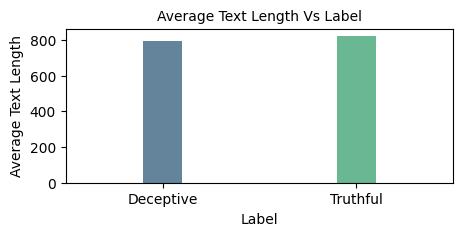

In [ ]:
color = sns.color_palette()

# Mapping numeric labels to string labels
label_mapping = {1: 'Truthful', 0: 'Deceptive'}
data['label_str'] = data['label'].map(label_mapping)

# Calculate text length
data['text_length'] = data['review_text'].apply(len)

# Calculate average text length by label
cnt_srs = data.groupby(["label_str"]).text_length.mean()

# Plot
plt.figure(figsize=(5, 2))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[0], width=0.2, palette="viridis")
plt.ylabel('Average Text Length', fontsize=10)
plt.xlabel('Label', fontsize=10)
plt.title('Average Text Length Vs Label', fontsize=10)
plt.xticks(rotation='horizontal')
plt.show()


## Number of reviews plots

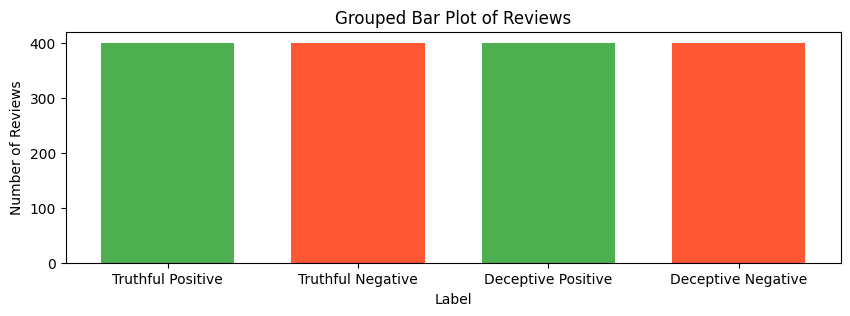

In [ ]:
data_plot = {
    'label': ['Truthful Positive', 'Truthful Negative', 'Deceptive Positive', 'Deceptive Negative'],
    'count': [400, 400, 400, 400],
}

df_plot = pd.DataFrame(data_plot)

# Grouped bar plot
plt.figure(figsize=(10, 3))
plt.bar(df_plot['label'], df_plot['count'], color=['#4CAF50', '#FF5733', '#4CAF50', '#FF5733'], width=0.7)

# Customize labels and title
plt.xlabel('Label')
plt.ylabel('Number of Reviews')
plt.title('Grouped Bar Plot of Reviews')
plt.show()


## Word Clouds

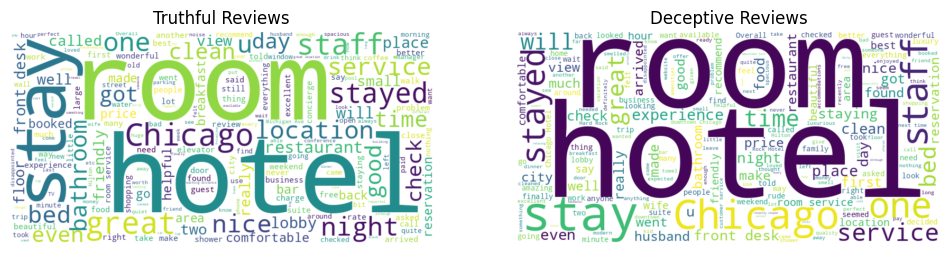

In [ ]:
# Separate review_text based on labels
truthful_reviews = ' '.join(data[data['label'] == 1]['review_text'].astype(str))
deceptive_reviews = ' '.join(data[data['label'] == 0]['review_text'].astype(str))

# Generate WordClouds for positive and negative reviews
wordcloud_truthful = WordCloud(width=800, height=400, background_color='white').generate(truthful_reviews)
wordcloud_deceptive = WordCloud(width=800, height=400, background_color='white').generate(deceptive_reviews)

# Plot the WordClouds side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_truthful, interpolation='bilinear')
plt.title('Truthful Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_deceptive, interpolation='bilinear')
plt.title('Deceptive Reviews')
plt.axis('off')

plt.show()


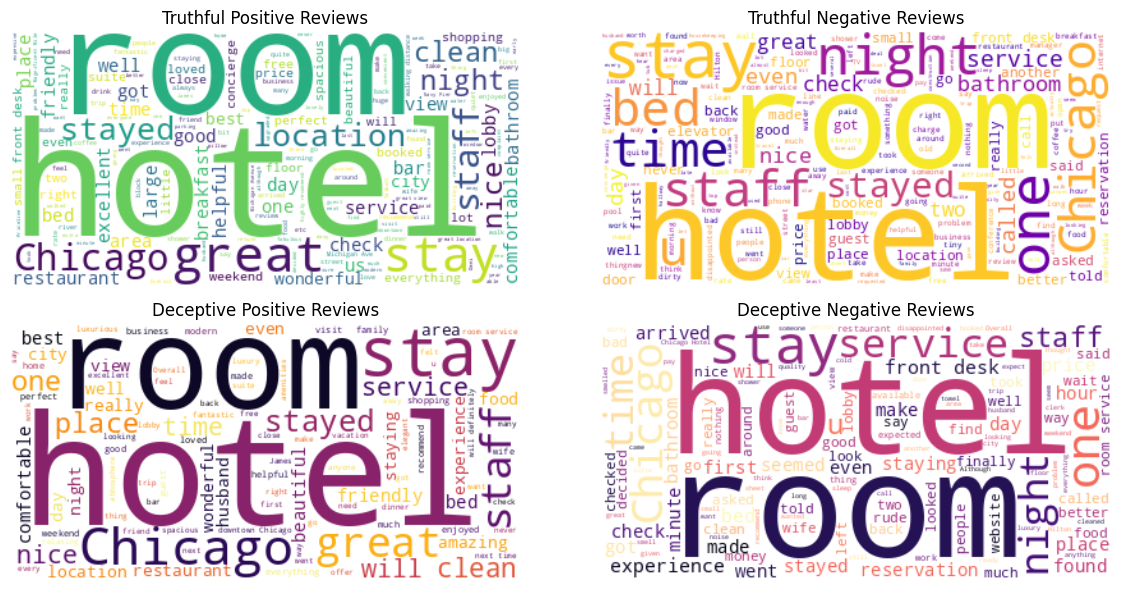

In [ ]:
truthful_reviews_pos = ' '.join(data[(data['label'] == 1) & (data['pos_neg'] == "pos")]['review_text'].astype(str))
truthful_reviews_neg = ' '.join(data[(data['label'] == 1) & (data['pos_neg'] == "neg")]['review_text'].astype(str))
deceptive_reviews_pos = ' '.join(data[(data['label'] == 0) & (data['pos_neg'] == "pos")]['review_text'].astype(str))
deceptive_reviews_neg = ' '.join(data[(data['label'] == 0) & (data['pos_neg'] == "neg")]['review_text'].astype(str))


# Define a function to generate and plot word clouds with different color schemes
def generate_and_plot_wordcloud(ax, text, title, colormap):
    wordcloud = WordCloud(width=400, height=200, background_color='white', colormap=colormap).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Specify different color schemes for each category
color_schemes = ['viridis', 'plasma', 'inferno', 'magma']

# Generate and plot word clouds for each category with different color schemes
generate_and_plot_wordcloud(axes[0, 0], truthful_reviews_pos, 'Truthful Positive Reviews', color_schemes[0])
generate_and_plot_wordcloud(axes[0, 1], truthful_reviews_neg, 'Truthful Negative Reviews', color_schemes[1])
generate_and_plot_wordcloud(axes[1, 0], deceptive_reviews_pos, 'Deceptive Positive Reviews', color_schemes[2])
generate_and_plot_wordcloud(axes[1, 1], deceptive_reviews_neg, 'Deceptive Negative Reviews', color_schemes[3])

# Adjust layout
plt.tight_layout()
plt.show()


# 2. Extracting text features for feature selection and adding them to the data



1.   Number of sentences ✓
2.   Review Length ✓ (shorter reviews fake Alsubari, 2021)
3.   Flesch score ✓
4.   Number of nouns ✓ (alsubari)
5.  Nummber of adjectives ✓ (alsubari)
6. Number of verbs ✓ (alsubari)
7. Number of content words ✓
8. Number of function words ✓
9. Sentiment Score ✓ (extravagant use of negative and positive words, Alsubari 2021 + extract storng positive and strong negative words)
10. Number of punctuation used ✓
11. Capitalization count ✓
12. Named entity recognition ✓
13. Number of digits ✓






- TfIdf Vectorizer with N-gram (bigram or trigram?) (x) alsubari used 4 grams, ahmed argues for the contrary, increasing the size of n-gram leads to lower accuracy for all classifiers




## number of sentences

In [ ]:
data['num_sentences'] = data['review_text'].apply(lambda x: len(str(x).split('.')))

## Flesch reading score

Minimum score is: 3.48, and the maximum score is: 101.29
   label  flesch_readability_score
0      0                 74.711088
1      1                 77.175725


<ipython-input-13-6b2d344b45ec>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="label", y="flesch_readability_score", data=readability_graph_data, palette="viridis", width = 0.7)


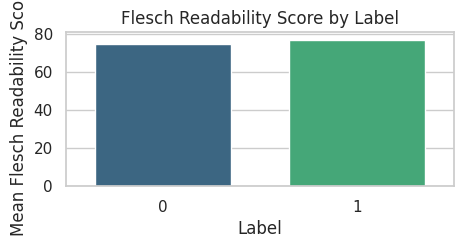

In [ ]:
data['flesch_readability_score'] = data['review_text'].apply(textstat.flesch_reading_ease)
print(f"Minimum score is: {data['flesch_readability_score'].min()}, and the maximum score is: {data['flesch_readability_score'].max()}")

# Calculate mean Flesch readability score by label
readability_graph_data = data.groupby(["label"]).flesch_readability_score.mean().reset_index()
print(readability_graph_data)

sns.set(style="whitegrid")
# Create a bar plot
plt.figure(figsize=(5, 2))
sns.barplot(x="label", y="flesch_readability_score", data=readability_graph_data, palette="viridis", width = 0.7)

plt.xlabel('Label')
plt.ylabel('Mean Flesch Readability Score')
plt.title('Flesch Readability Score by Label')

plt.show()

## Count content and function words

In [ ]:
# Function to count content and function words, and specific POS
def count_words_and_pos(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    # Define POS tags for content and function words
    content_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}
    function_pos = {'IN', 'PRP', 'PRP$', 'DT', 'CC', 'MD'}

    # Counters
    content_count = 0
    function_count = 0
    pos_counts = Counter()

    for word, pos in tagged:
        if pos in content_pos:
            content_count += 1
        elif pos in function_pos:
            function_count += 1
        pos_counts[pos] += 1

    return content_count, function_count, pos_counts

# Apply the function to the 'review_text' column and create new columns
data[['content_word_count', 'function_word_count', 'pos_counts']] = data['review_text'].apply(lambda x: pd.Series(count_words_and_pos(x)))

data['verb_count'] = data['pos_counts'].apply(lambda x: sum([x.get(pos, 0) for pos in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
data['noun_count'] = data['pos_counts'].apply(lambda x: sum([x.get(pos, 0) for pos in ['NN', 'NNS', 'NNP', 'NNPS']]))
data['adjective_count'] = data['pos_counts'].apply(lambda x: sum([x.get(pos, 0) for pos in ['JJ', 'JJR', 'JJS']]))

# dropping the 'pos_counts' column
data.drop('pos_counts', axis=1, inplace=True)

print(data.head())

            ID  label pos_neg  \
0  sheraton_14      1     pos   
1   talbott_13      0     pos   
2   sheraton_2      0     neg   
3    palmer_10      1     neg   
4     james_17      1     pos   

                                         review_text  sentences  label_str  \
0  The sheraton was a wonderful hotel! When me an...          7   Truthful   
1  My husband and I decided to plan a romantic ge...          7  Deceptive   
2  The Sheraton Chicago Hotel and Towers is not t...         10  Deceptive   
3  First of all, Expedia.com charged me for an ad...         11   Truthful   
4  took a weekend trip with my wife. got a great ...          5   Truthful   

   text_length  num_sentences  flesch_readability_score  content_word_count  \
0          385              6                     77.23                  41   
1          655              8                     71.75                  63   
2          874             11                     64.71                  87   
3          992  

<ipython-input-17-89da7caeec87>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = data.groupby('label').mean()


<Figure size 1000x600 with 0 Axes>

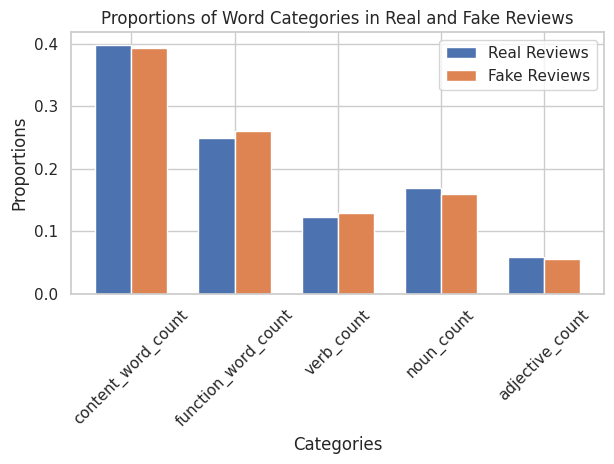

In [ ]:
# Group the data by 'label' and calculate the mean for each group
grouped_data = data.groupby('label').mean()

# Prepare data for plotting
categories = ['content_word_count', 'function_word_count', 'verb_count', 'noun_count', 'adjective_count']
fake_reviews = grouped_data.loc[0, categories]
real_reviews = grouped_data.loc[1, categories]

# Normalize the data to get proportions
fake_reviews /= fake_reviews.sum()
real_reviews /= real_reviews.sum()

# Plotting
plt.figure(figsize=(10, 6))  # Increase the figure size
fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(categories))

bar1 = ax.bar(index, real_reviews, bar_width, label='Real Reviews')
bar2 = ax.bar([i + bar_width for i in index], fake_reviews, bar_width, label='Fake Reviews')

ax.set_xlabel('Categories')
ax.set_ylabel('Proportions')
ax.set_title('Proportions of Word Categories in Real and Fake Reviews')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(categories, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


## Tokenizing, filtering for stopwords and lemmatizing the text

In [ ]:
lemmatizer = WordNetLemmatizer()

# Creating the stopwords list
stop_words = set(stopwords.words('english'))

# In the bottom sections we define some small but useful filtering functions
def tokenize(text):
  text = re.sub(r'\s+', ' ', text).strip()
  tokenized_text = nltk.tokenize.word_tokenize(text, language='english')
  return tokenized_text

def remove_stopwords(tokenized_text):
  filtered_text = [word for word in tokenized_text if not word.lower() in stop_words]
  return ' '.join(filtered_text)

def remove_stopwords_list(tokenized_text):
  filtered_text_list = [word for word in tokenized_text if not word.lower() in stop_words]
  return filtered_text_list

def lem_words(filtered_text):
  lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
  return ' '.join(lemmatized_text)

# We are adding different columns to the dataset
data['tokenized_text'] = data['review_text'].map(tokenize)
data['filtered_text'] = data['tokenized_text'].map(remove_stopwords)
data['filtered_text_list'] = data['tokenized_text'].map(remove_stopwords_list)
data['lemmatized_text'] = data['filtered_text_list'].map(lem_words)

## Most frequent words

In [ ]:
# Getting the most common words
truthful_reviews_pos_tokenized = tokenize(truthful_reviews_pos.lower())
truthful_reviews_neg_tokenized = tokenize(truthful_reviews_neg.lower())
deceptive_reviews_pos_tokenized = tokenize(deceptive_reviews_pos.lower())
deceptive_reviews_neg_tokenized = tokenize(deceptive_reviews_neg.lower())

truthful_reviews_pos_filtered = remove_stopwords_list(truthful_reviews_pos_tokenized)
truthful_reviews_neg_filtered = remove_stopwords_list(truthful_reviews_neg_tokenized)
deceptive_reviews_pos_filtered= remove_stopwords_list(deceptive_reviews_pos_tokenized)
deceptive_reviews_neg_filtered= remove_stopwords_list(deceptive_reviews_neg_tokenized)

truthful_reviews_pos_FreqDist = nltk.FreqDist(truthful_reviews_pos_filtered)
deceptive_reviews_pos_FreqDist = nltk.FreqDist(deceptive_reviews_pos_filtered)

truthful_reviews_pos_FreqDist.most_common(10)
list(deceptive_reviews_pos_FreqDist.most_common(20))

[('.', 2579),
 (',', 1585),
 ('hotel', 868),
 ('chicago', 589),
 ('!', 466),
 ('room', 412),
 ('stay', 356),
 ('great', 256),
 ('staff', 220),
 ('rooms', 183),
 ('service', 182),
 ('would', 174),
 ('stayed', 163),
 ("n't", 146),
 ('time', 146),
 ("'s", 136),
 ('one', 127),
 ('like', 125),
 ('clean', 123),
 ('comfortable', 118)]

In [ ]:
test_list = list(truthful_reviews_pos_FreqDist.most_common(20))
print([word for word in test_list if word[0].isalpha()])

[('hotel', 709), ('room', 539), ('great', 406), ('chicago', 300), ('stay', 298), ('staff', 251), ('location', 214), ('stayed', 196), ('would', 191), ('rooms', 172), ('service', 161), ('nice', 151), ('clean', 148)]


## Sentiment Analysis

In [7]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return sia.polarity_scores(text)

data['vader_scores'] = data['review_text'].apply(get_sentiment_scores)
data = pd.concat([data.drop(['vader_scores'], axis=1), data['vader_scores'].apply(pd.Series)], axis=1)

## Counting Puncutation

In [ ]:
punctuation = ['.', ',', '!', '?', '\'', '\\', '\"', '(', ')', ';', ':']
punctuation_counts = []

for text in data["review_text"]:
    text = str(text)
    count = sum(1 for char in text if char in punctuation)
    punctuation_counts.append(count)

data['punctuation_count'] = punctuation_counts


## Capitalization count

In [ ]:
final_caps_counts = []

for text in data["review_text"]:
    text = str(text)
    caps_count = sum(1 for character in text if character.isupper())
    final_caps_counts.append(caps_count)

data['cap_count'] = final_caps_counts

## NER count

In [ ]:
nlp = spacy.load("en_core_web_sm")

def transform(texts):
    ner_counts = []
    for doc in nlp.pipe(texts, disable=["parser"]):
        entities = [ent.label_ for ent in doc.ents]
        ner_counts.append(len(entities))
    return ner_counts

data['ner_count'] = transform(data['review_text'])

## Digit Count

In [ ]:
def count_digits_in_column(df, column_name):
    # Calculate the number of digits in each row and create a new column
    df['digit_count'] = df[column_name].apply(lambda x: sum(c.isdigit() for c in x))
    return df

data = count_digits_in_column(data, 'review_text')

In [ ]:
#data.drop(['filtered_text_list', "tokenized_text"], axis = 1, inplace=True)
data.head(5)

,ID,label,pos_neg,review_text,sentences,label_str,text_length,num_sentences,flesch_readability_score,content_word_count,...,filtered_text_list,lemmatized_text,neg,neu,pos,compound,punctuation_count,cap_count,ner_count,digit_count
0,sheraton_14,1,pos,The sheraton was a wonderful hotel! When me an...,7,Truthful,385,6,77.23,41,...,"[sheraton, wonderful, hotel, !, mom, flew, rea...",sheraton wonderful hotel ! mom flew really tir...,0.096,0.735,0.169,0.8217,7,7,1,0
1,talbott_13,0,pos,My husband and I decided to plan a romantic ge...,7,Deceptive,655,8,71.75,63,...,"[husband, decided, plan, romantic, get-away, o...",husband decided plan romantic get-away one yea...,0.000,0.844,0.156,0.9565,11,18,5,0
2,sheraton_2,0,neg,The Sheraton Chicago Hotel and Towers is not t...,10,Deceptive,874,11,64.71,87,...,"[Sheraton, Chicago, Hotel, Towers, hotel, pers...",Sheraton Chicago Hotel Towers hotel person wis...,0.000,0.840,0.160,0.9694,11,14,2,0
3,palmer_10,1,neg,"First of all, Expedia.com charged me for an ad...",11,Truthful,992,9,71.65,97,...,"[First, ,, Expedia.com, charged, additional, p...","First , Expedia.com charged additional person ...",0.050,0.811,0.139,0.9760,18,18,8,2
4,james_17,1,pos,took a weekend trip with my wife. got a great ...,5,Truthful,290,6,86.30,35,...,"[took, weekend, trip, wife, ., got, great, rat...",took weekend trip wife . got great rate valet ...,0.080,0.728,0.191,0.6757,9,0,2,0


## Saving the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/SA/features_table.csv'

Mounted at /content/drive


In [ ]:
data.to_csv(file_path, encoding='utf-8', index=False)

# 3. Splitting the dataset

Split train and test data
how many folds are we using for validation? ahmed used 5-fold cross validation

In [ ]:
y = data["label"]
X = data["review_text"]

In [ ]:
train_df_70, test_df_30 = train_test_split(data, test_size=0.3, random_state=13, stratify=data["label"])

In [ ]:
# Extracting the target variable 'label'
y_train = train_df_70['label']
y_test = test_df_30['label']
X_train = train_df_70[[ "review_text"]]
X_test = test_df_30[["review_text"]]

print(X_train.columns)

Index(['review_text'], dtype='object')


In [ ]:
print(X_train.columns)
print(X_test.columns)

Index(['review_text'], dtype='object')
Index(['review_text'], dtype='object')


# 4. Features

Supervised learning:
- Logistic Regression (Ahmed, best results)
- Stochastic Gradient Descent (ahmed)
- Naive Bayes (Alsubari et al, 2021)
- Ensemble technique (random forest and adaptive boost) - (Alsubari et al, 2021)
- Support Vector Machines (ahmed -90% accuracy)

Sources: alsubari - https://cdn.techscience.cn/ueditor/files/cmc/TSP_CMC_70-2/TSP_CMC_19625/TSP_CMC_19625.pdf

## Feature Correlation Map

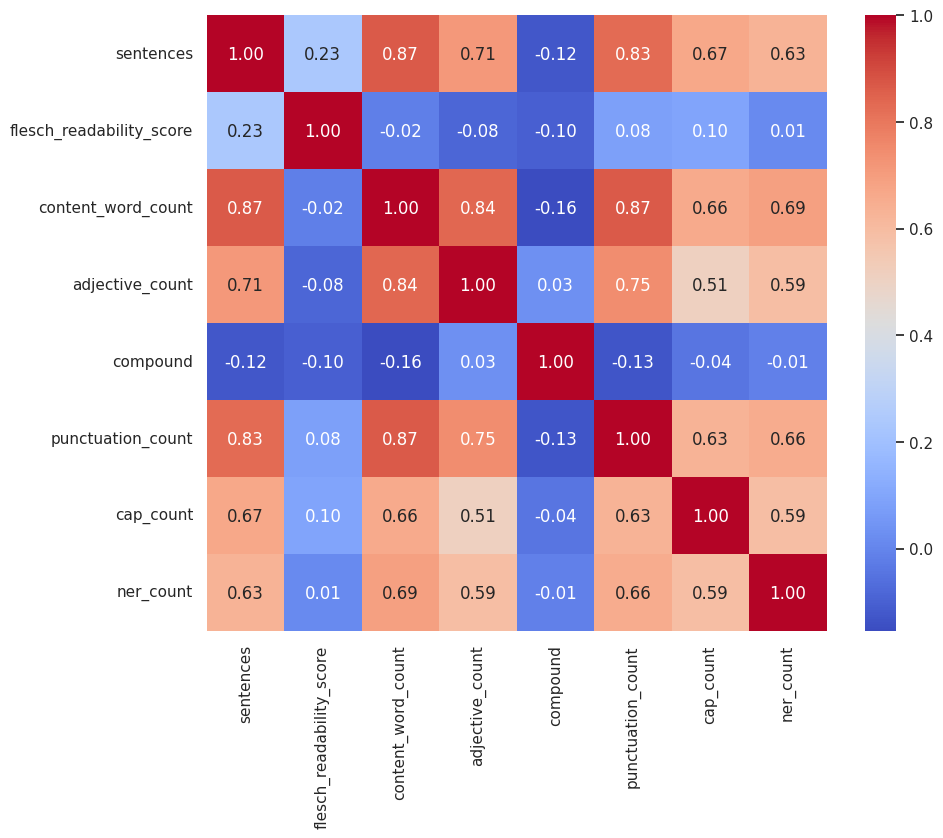

In [ ]:
data_corr = [col for col in data.columns if col not in ('ID', 'label', 'label_str', "filtered_text_list", "filtered_text", "tokenized_text", "pos_neg", "review_text", "content_function_pos_counts", "pos_counts",
                                                         "lemmatized_text", 'neg', 'neu', 'pos',  "filtered_text_joined",
                                                         #features I dropped after feature selection : "content_word_count", "function_word_count", "text_length","digit_count"
                                                        "adj_count", "noun_count", "verb_count", "num_sentences", "function_word_count", "text_length", "digit_count")]

correlation_df = data[data_corr]
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

## Functions to extract features

In [ ]:
# NLP model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

def count_words_and_pos(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    # Define POS tags for content and function words
    content_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}
    function_pos = {'IN', 'PRP', 'PRP$', 'DT', 'CC', 'MD'}

    # Counters
    content_count = 0
    function_count = 0
    pos_counts = Counter()

    for word, pos in tagged:
        if pos in content_pos:
            content_count += 1
        elif pos in function_pos:
            function_count += 1
        pos_counts[pos] += 1

    return content_count, function_count, pos_counts

# Custom transformer for counting content, function words, and specific POS
class Content_Extractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        counts = [count_words_and_pos(text) for text in texts]
        content_counts, function_counts, pos_counts_list = zip(*counts)

        return np.array(content_counts).reshape(-1, 1)

class TfidfBigramVectorizer(TfidfVectorizer):
    def __init__(self, **kwargs):
        # Make sure to call the super class's __init__ with all arguments.
        super(TfidfBigramVectorizer, self).__init__(ngram_range=(2, 2), **kwargs)

class NerExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        ner_counts = []
        for doc in nlp.pipe(texts, disable=["parser"]):
            entities = [ent.label_ for ent in doc.ents]
            ner_counts.append(len(entities))
        return np.array(ner_counts).reshape(-1, 1)


class DigitCountExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, texts):
        digit_counts = [sum(c.isdigit() for c in text) for text in texts]
        return np.array(digit_counts).reshape(-1, 1)

# SentimentAnalysis implementation
class SentimentScoreExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        vader_scores = [sia.polarity_scores(text) for text in texts]
        compound_scores = [score['compound'] for score in vader_scores]
        return np.array(compound_scores).reshape(-1, 1)


# function to count punctuation within the reviews
class PunctuationCounterExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        punctuation = ['.', ',', '!', '?', '\'', '\\', '\"', '(', ')', ';', ':']
        punctuation_counts = []
        for text in texts:
            count = sum(1 for char in text if char in punctuation)
            punctuation_counts.append(count)
        return np.array(punctuation_counts).reshape(-1, 1)

# function to count capitalized letters within the reviews
class CapitalizationExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        caps_counts = []

        for text in texts:
            caps_count = sum(1 for character in text if character.isupper())
            caps_counts.append(caps_count)

        return np.array(caps_counts).reshape(-1, 1)

#Flesch Readability Score as feature
class FleschReadabilityExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        readability_scores = [textstat.flesch_reading_ease(text) for text in texts]
        return np.array(readability_scores).reshape(-1, 1)

# Models & Evaluation

## Pipeline builder

In [ ]:
def build_custom_pipeline(classifier, features):
    pipeline = Pipeline([
        ('features', features),
        ('scale', StandardScaler(with_mean=False)),
        ('classifier', classifier)
    ])
    return pipeline

combined_features = FeatureUnion([
    ('ner_feature', NerExtractor()),
    ('tfidf_bigram', TfidfBigramVectorizer()),
    ('sentiment_score', SentimentScoreExtractor()),
    ('punct_count', PunctuationCounterExtractor()),
    ('content_count', Content_Extractor()),
    ('flesch', FleschReadabilityExtractor()),
    ('cap_count', CapitalizationExtractor()),
])

## Evaluation

In [ ]:
def print_metrics_and_plot_confusion_matrix(classifier, X_test, y_test, model_name, labels=None):
    """
    Prints classification metrics and plots the confusion matrix for a given classifier and test data.

    :param classifier: Trained classifier (e.g., SVM classifier)
    :param X_test: Test features
    :param y_test: True labels for the test data
    :param model_name: A string with the name of the model
    :param labels: List of label names to be used in the confusion matrix and classification report
    """
    # Generate predictions
    y_pred = classifier.predict(X_test)

    # Calculate accuracy and display it
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy = {accuracy * 100:.2f}%\n")

    # Generate a classification report
    report_kwargs = {'output_dict': True}
    if labels:
        report_kwargs['target_names'] = labels
    report = classification_report(y_test, y_pred, **report_kwargs)
    report_df = pd.DataFrame(report).transpose()
    print(report_df.to_string())

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)

    # Add labels in the center of the cells
    labels_text = ["True Neg", "False Pos", "False Neg", "True Pos"]
    labels_counts = ["{} ({:.2f}%)".format(value, percentage) for value, percentage in zip(cm.flatten(), (cm_normalized.flatten()*100))]
    labels_combined = [f"{text}\n{count}" for text, count in zip(labels_text, labels_counts)]

    for i in range(4):
        text_color = 'white' if cm_normalized.flatten()[i] > 0.5 else 'black'
        ax.text((i % 2) + 0.5, (i // 2) + 0.5, labels_combined[i],
                horizontalalignment='center', verticalalignment='center', color=text_color)

# Logistic Regression - 83.93%

In [ ]:
classifier = LogisticRegression()
pipeline_log = build_custom_pipeline(classifier, combined_features)

# Fit the pipeline on the training data - not necessary for k fold cross validation
#pipeline_log.fit(X_train["review_text"], y_train)

### Score on 5 fold cross validation for LR

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross validation on the entire dataset
scores = cross_val_score(pipeline_log, X, y, cv=kfold, scoring='accuracy')

# Print the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores)}')

Cross-validation scores: [0.840625 0.828125 0.8125   0.8375   0.878125]
Average Score: 0.8393750000000001


## Evaluation Matrix

Accuracy = 85.00%

              precision    recall  f1-score  support
deceptive      0.793706  0.945833  0.863118   240.00
truthful       0.932990  0.754167  0.834101   240.00
accuracy       0.850000  0.850000  0.850000     0.85
macro avg      0.863348  0.850000  0.848610   480.00
weighted avg   0.863348  0.850000  0.848610   480.00


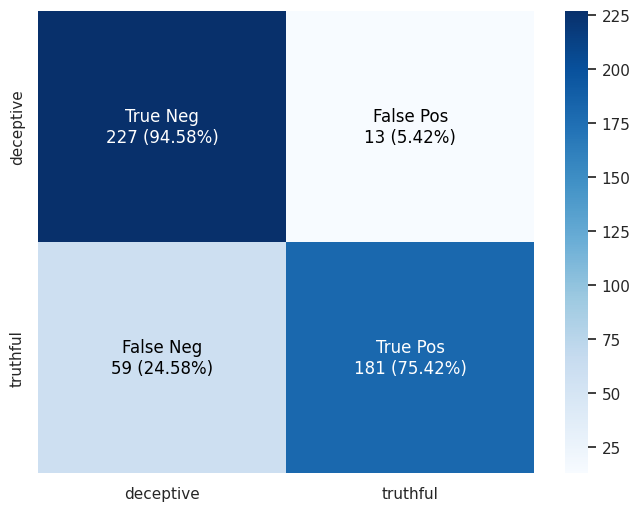

In [ ]:
#print_metrics_and_plot_confusion_matrix(pipeline_log, X_test["review_text"], y_test, model_name='Logistic Regression', labels=['deceptive', 'truthful'])

# Random Forest - 78.81%

In [ ]:
classifier = RandomForestClassifier() #(n_estimators=100)
pipeline_rdn = build_custom_pipeline(classifier, combined_features)

# Fit the pipeline on the training data - not for k fold cross
#pipeline_rdn.fit(X_train["review_text"], y_train)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_rdn, X, y, cv=kfold, scoring='accuracy')

# Round the scores to 4 decimal places
rounded_scores = np.round(scores, 4)

# Print the rounded scores and the average score
print("Cross-validation scores:", rounded_scores)
print(f'Average Score: {np.mean(rounded_scores):.4f}')


Cross-validation scores: [0.8    0.7812 0.8125 0.7719 0.775 ]
Average Score: 0.7881


## Evaluation Matrix when using train and test

Accuracy = 79.79%

              precision    recall  f1-score     support
deceptive      0.769811  0.850000  0.807921  240.000000
truthful       0.832558  0.745833  0.786813  240.000000
accuracy       0.797917  0.797917  0.797917    0.797917
macro avg      0.801185  0.797917  0.797367  480.000000
weighted avg   0.801185  0.797917  0.797367  480.000000


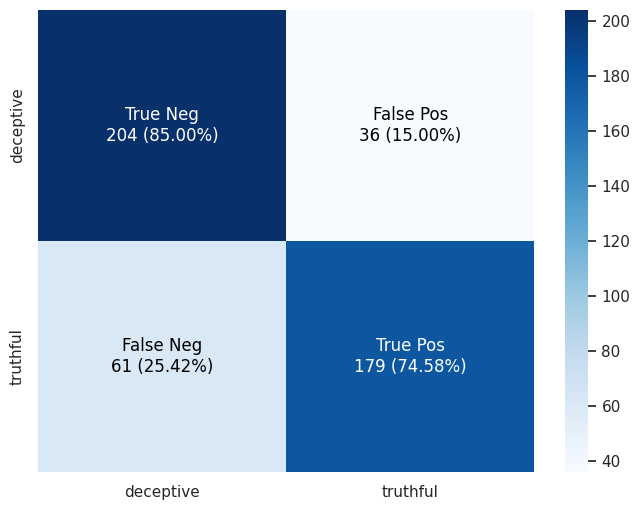

In [ ]:
#print_metrics_and_plot_confusion_matrix(pipeline_rdn, X_test["review_text"], y_test, model_name='Logistic Regression', labels=['deceptive', 'truthful'])

# AdaBoost - 76.19%

In [ ]:
sgd_hinge = SGDClassifier(loss="hinge")

pipeline_with_adaboost_samme = Pipeline([
    ('features', combined_features),
    ('scale', StandardScaler(with_mean=False)),
    ('classifier', AdaBoostClassifier(
        estimator=sgd_hinge,
        n_estimators=50,
        learning_rate=1.0,
        algorithm='SAMME'
    ))
])

# Fit and use the pipelines if needed
#pipeline_with_adaboost_samme.fit(X_train["review_text"], y_train)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_with_adaboost_samme, X, y, cv=kfold, scoring='accuracy')

# Round the scores to 4 decimal places
rounded_scores = np.round(scores, 4)

# Print the rounded scores and the average score
print("Cross-validation scores:", rounded_scores)
print(f'Average Score: {np.mean(rounded_scores):.4f}')


Cross-validation scores: [0.75   0.7844 0.7688 0.75   0.7562]
Average Score: 0.7619


## Evaluation Matrix

Accuracy = 74.79%

              precision    recall  f1-score     support
deceptive      0.755365  0.733333  0.744186  240.000000
truthful       0.740891  0.762500  0.751540  240.000000
accuracy       0.747917  0.747917  0.747917    0.747917
macro avg      0.748128  0.747917  0.747863  480.000000
weighted avg   0.748128  0.747917  0.747863  480.000000


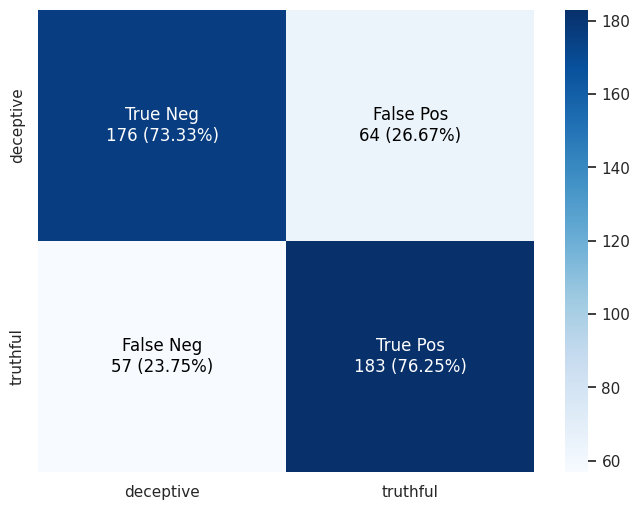

In [ ]:
#print_metrics_and_plot_confusion_matrix(pipeline_with_adaboost_samme, X_test["review_text"], y_test, model_name='Adaboost', labels=['deceptive', 'truthful'])

# Suport Vector Machine - 84.50%

In [ ]:
classifier = LinearSVC(C=1.0, max_iter=1000)

pipeline_linear_SVC = build_custom_pipeline(classifier, combined_features)

# Training the model
#pipeline_linear_SVC.fit(X_train["review_text"], y_train)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_linear_SVC, X, y, cv=kfold, scoring='accuracy')

# Round the scores to 4 decimal places
rounded_scores = np.round(scores, 4)

# Print the rounded scores and the average score
print("Cross-validation scores:", rounded_scores)
print(f'Average Score: {np.mean(rounded_scores):.4f}')

Cross-validation scores: [0.8438 0.8312 0.825  0.8406 0.8844]
Average Score: 0.8450


### Evaluation Matrix

Accuracy = 85.42%

              precision    recall  f1-score     support
deceptive      0.799296  0.945833  0.866412  240.000000
truthful       0.933673  0.762500  0.839450  240.000000
accuracy       0.854167  0.854167  0.854167    0.854167
macro avg      0.866485  0.854167  0.852931  480.000000
weighted avg   0.866485  0.854167  0.852931  480.000000


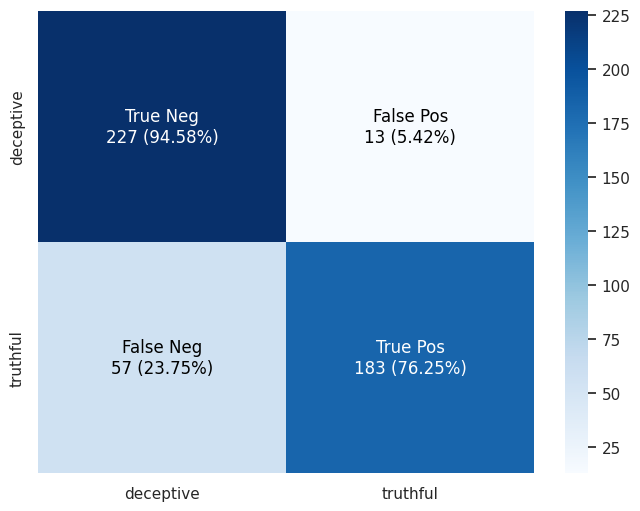

In [ ]:
#print_metrics_and_plot_confusion_matrix(pipeline_linear_SVC, X_test["review_text"], y_test, model_name='SVM', labels=['deceptive', 'truthful'])

# Feature Selection with subset - 81% accuracy
All features combine achieve a higher accuracy

In [ ]:
# NLP model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

def count_words_and_pos(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    # Define POS tags for content and function words
    content_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}
    function_pos = {'IN', 'PRP', 'PRP$', 'DT', 'CC', 'MD'}

    # Counters
    content_count = 0
    function_count = 0
    pos_counts = Counter()

    for word, pos in tagged:
        if pos in content_pos:
            content_count += 1
        elif pos in function_pos:
            function_count += 1
        pos_counts[pos] += 1

    return content_count, function_count, pos_counts

# Custom transformer for counting content, function words, and specific POS
class Content_Extractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        counts = [count_words_and_pos(text) for text in texts]
        content_counts, function_counts, pos_counts_list = zip(*counts)

        return np.array(content_counts).reshape(-1, 1)

class Function_Extractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        counts = [count_words_and_pos(text) for text in texts]
        content_counts, function_counts, pos_counts_list = zip(*counts)

        return np.array(function_counts).reshape(-1, 1)

class TfidfBigramVectorizer(TfidfVectorizer):
    def __init__(self, **kwargs):
        super(TfidfBigramVectorizer, self).__init__(ngram_range=(2, 2), **kwargs)

class NerExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        ner_counts = []
        for doc in nlp.pipe(texts, disable=["parser"]):
            entities = [ent.label_ for ent in doc.ents]
            ner_counts.append(len(entities))
        return np.array(ner_counts).reshape(-1, 1)

# Custom transformer for review length feature
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        return np.array([len(text) for text in texts]).reshape(-1, 1)

class DigitCountExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, texts):
        digit_counts = [sum(c.isdigit() for c in text) for text in texts]
        return np.array(digit_counts).reshape(-1, 1)

# SentimentAnalysis implementation
class SentimentScoreExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        vader_scores = [sia.polarity_scores(text) for text in texts]
        compound_scores = [score['compound'] for score in vader_scores]
        return np.array(compound_scores).reshape(-1, 1)

# function to count punctuation within the reviews
class PunctuationCounterExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        punctuation = ['.', ',', '!', '?', '\'', '\\', '\"', '(', ')', ';', ':']
        punctuation_counts = []
        for text in texts:
            count = sum(1 for char in text if char in punctuation)
            punctuation_counts.append(count)
        return np.array(punctuation_counts).reshape(-1, 1)

# function to count capitalized letters within the reviews
class CapitalizationExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        caps_counts = []

        for text in texts:
            caps_count = sum(1 for character in text if character.isupper())
            caps_counts.append(caps_count)

        return np.array(caps_counts).reshape(-1, 1)


#Flesch Readability Score as feature
class FleschReadabilityExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        readability_scores = [textstat.flesch_reading_ease(text) for text in texts]
        return np.array(readability_scores).reshape(-1, 1)

text_based_features = FeatureUnion([
    ('tfidf_bigram', TfidfBigramVectorizer())
])

nlp_based_features = FeatureUnion([
    ('ner_feature', NerExtractor()),
    ('punct_count', PunctuationCounterExtractor()),
    ('content_count', Content_Extractor()),
    ('flesch', FleschReadabilityExtractor()),
    ('cap_count', CapitalizationExtractor())
])

sentiment_based_features = FeatureUnion([
    ('sentiment_score', SentimentScoreExtractor()),
])

combined_features = FeatureUnion([
    ('text_based', text_based_features),
    ('nlp_based', nlp_based_features),
    ('sentiment_based', sentiment_based_features),
])

# Final Pipeline
pipeline_log_reg = Pipeline([
    ('features', combined_features),
    ('scale', StandardScaler(with_mean=False)),
    ('classifier', LogisticRegression())
])

# Training the model
pipeline_log_reg.fit(X_train["review_text"], y_train)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_based',
                                                 FeatureUnion(transformer_list=[('tfidf_bigram',
                                                                                 TfidfBigramVectorizer())])),
                                                ('nlp_based',
                                                 FeatureUnion(transformer_list=[('ner_feature',
                                                                                 NerExtractor()),
                                                                                ('punct_count',
                                                                                 PunctuationCounterExtractor()),
                                                                                ('content_count',
                                                                                 Content_Extractor()),
                                                                                ('flesch',
                                                                                 FleschReadabilityExtractor()),
                                                                                ('cap_count',
                                                                                 CapitalizationExtractor())])),
                                                ('sentiment_based',
                                                 FeatureUnion(transformer_list=[('sentiment_score',
                                                                                 SentimentScoreExtractor())]))])),
                ('scale', StandardScaler(with_mean=False)),
                ('classifier', LogisticRegression())])

In [ ]:
feature_subset_names = ['text_based', 'nlp_based', 'sentiment_based']

for subset_name in feature_subset_names:
    # Create a new pipeline with the selected feature subset
    pipeline_subset = Pipeline([
        ('features', combined_features.set_params(transformer_weights={subset_name: 1.0})),
        ('scale', StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression())
    ])

    # Perform cross-validation and evaluate the model
    scores = cross_val_score(pipeline_subset, X_train["review_text"], y_train, cv=5, scoring='accuracy')
    print(f"Accuracy for {subset_name}: {np.mean(scores)}")


Accuracy for text_based: 0.8098214285714285
Accuracy for nlp_based: 0.8098214285714285
Accuracy for sentiment_based: 0.8098214285714285


# 6. Feature importance matrix Logistic Regressiom

## Get Feature Names

In [ ]:
def get_feature_names(feature_union):
    feature_names = []

    for transformer_name, transformer in feature_union.transformer_list:
        if isinstance(transformer, Pipeline):
            final_transformer = transformer.steps[-1][1]
        else:
            final_transformer = transformer

        if hasattr(final_transformer, 'get_feature_names_out'):
            names = final_transformer.get_feature_names_out()
        elif hasattr(final_transformer, 'get_feature_names'):
            names = final_transformer.get_feature_names()
        else:
            try:
                num_features = final_transformer.transform(np.zeros((1, 0))).shape[1]
                names = [f"{transformer_name}_{i}" for i in range(num_features)]
            except:
                names = [transformer_name]

        feature_names.extend(names)

    return feature_names

## Feature Importance LR with ELI5

In [ ]:
# Function to extract feature names from FeatureUnion
def get_feature_names(feature_union, input_features=None):
    feature_names = []
    for transformer_name, transformer in feature_union.transformer_list:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(input_features)
        elif hasattr(transformer, 'get_feature_names'):
            names = transformer.get_feature_names()
        else:
            names = [f"{transformer_name}_{i}" for i in range(transformer.transform(X_train["review_text"]).shape[1])]
        feature_names.extend(names)
    return feature_names

# Get feature names
feature_names = get_feature_names(pipeline_log.named_steps['features'])

# Display feature importances
eli5.show_weights(pipeline_log.named_steps['classifier'], feature_names=feature_names, top = 20)


## Feature importance LR with Coefficients
Did not figure out how to do it with coefficients for k-fold

In [ ]:
pipeline_log.fit(X_train["review_text"], y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ner_feature', NerExtractor()),
                                                ('tfidf_bigram',
                                                 TfidfBigramVectorizer()),
                                                ('sentiment_score',
                                                 SentimentScoreExtractor()),
                                                ('punct_count',
                                                 PunctuationCounterExtractor()),
                                                ('content_count',
                                                 Content_Extractor()),
                                                ('flesch',
                                                 FleschReadabilityExtractor()),
                                                ('cap_count',
                                                 CapitalizationExtractor())])),
                ('scale', StandardScaler(with_mean=False)),
                ('classifier', LogisticRegression())])

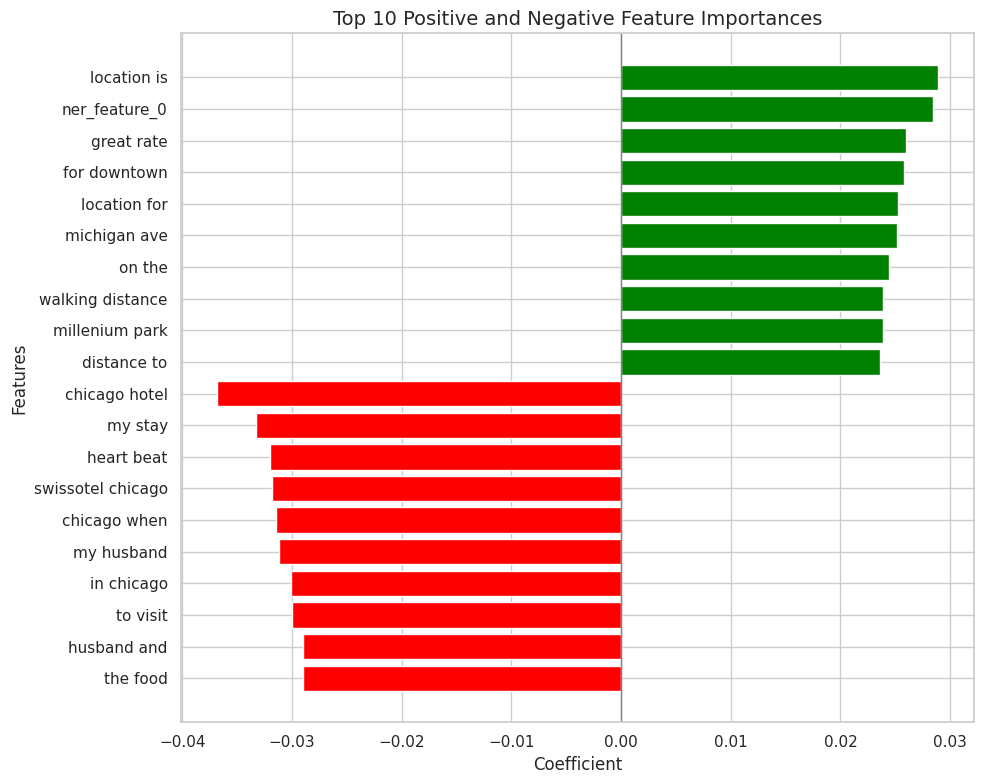

In [ ]:
feature_union = pipeline_log.named_steps['features']
feature_names = get_feature_names(feature_union)

# Retrieve the logistic regression estimator from the pipeline
log_reg = pipeline_log.named_steps['classifier']

# Get the coefficients from the logistic regression estimator
coefficients = log_reg.coef_[0]

# Create a DataFrame for the coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calculate the absolute value of the coefficients for ranking
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()

# Separate the top 10 positive and top 10 negative features
top_10_positive = feature_importance[feature_importance['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(10)
top_10_negative = feature_importance[feature_importance['Coefficient'] < 0].sort_values(by='Coefficient').head(10)

# Concatenate the top positive and negative features
top_features = pd.concat([top_10_positive, top_10_negative])

# Create a bar plot
plt.figure(figsize=(10, 8))
colors = ['green' if c > 0 else 'red' for c in top_features['Coefficient']]
plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 10 Positive and Negative Feature Importances', fontsize=14)
plt.axvline(x=0, color='grey', lw=1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()